# Исследования в области генерации текста с помощью методов NLP

Я обладаю небольшими вычислительными мощностями, поэтому свою модель буду строить на основе LSTM, GRU и предобученных трансформерах (BERT-like)

Сбор данных: на 3-м курсе нам подсунули немного философии в расписание, поэтому попробую создать модель, которая будет генерировать философские цитаты. Из найденных датасетов: на русском языке ничего найдено не было, однако был найден датасет на kaggle: https://www.kaggle.com/datasets/akmittal/quotes-dataset/code. Он на английском, поэтому переводом пришлось заниматься вручную. Какие особенности были выявлены: в данных присутствуют цитаты на арабском. А также есть отсутствие пробелов между предложениями и в некоторых случаях словами. Для последующего анализа и обучения мною было отобрано 2210 строк (ruFile.txt).

In [105]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from myLibrary.preprocessing import DataProcessor
from myLibrary.vocab import Vocab

import torch
from  torch.utils.data import Dataset, DataLoader

In [26]:
with open('data/ruFile.txt', 'r', encoding='utf-8') as file:
    data = file.readlines()
    extract_data = []
    for quote in data:
        extract_data.append(re.sub(r'([^\w\s-])', r'\1 ', quote))
    df = pd.DataFrame(extract_data, columns=['Quote'])

display(df.shape)
print(df.iloc[:10, 0].values, sep='\n')

(2210, 1)

['" Обычно,  когда люди говорят о теории " просачивания" ,  это имеет отношение к экономике.  Предполагается,  что чем богаче становятся люди на вершине общества,  тем больше богатства может просачиваться к людям внизу.  Конечно,  на самом деле так никогда не получается,  потому что если есть две вещи,  которые люди наверху терпеть не могут,  то это утечка и переполнение" . \n'
 'Ничто так не способствует успокоению ума,  как устойчивая цель\n'
 'Никогда не тратьте впустую время на что-то важное,  когда за окном закат,  под которым вам следовало бы сидеть! \n'
 '" Что делает телевидение,  и есть причина,  по которой " Щ. И. Т. "  работает так хорошо,  как оно работает,  так это то,  что оно имеет дело с отношениями.  Оно имеет дело с очень мелкими,  межличностными способами,  которыми люди одновременно любят и ненавидят друг друга" . \n'
 '" Иногда потеря домашнего животного более болезненна,  чем потеря человека,  потому что в случае с домашним животным вы не притворялись,  что любите

In [27]:
dp = DataProcessor(df)
clear_data = dp.get_clear_data('Quote')

In [28]:
print(clear_data.iloc[:3, 1].values, sep='\n')

['обычно когда люди говорят о теории просачивания это имеет отношение к экономике предполагается что чем богаче становятся люди на вершине общества тем больше богатства может просачиваться к людям внизу конечно на самом деле так никогда не получается потому что если есть две вещи которые люди наверху терпеть не могут то это утечка и переполнение'
 'ничто так не способствует успокоению ума как устойчивая цель'
 'никогда не тратьте впустую время на что-то важное когда за окном закат под которым вам следовало бы сидеть']


In [29]:
dp.write_clear_data('_data.txt')

In [30]:
data = pd.read_csv('data/clear_data.csv')
data.head()

,Quote,Clear
0,""" Обычно, когда люди говорят о теории "" проса...",обычно когда люди говорят о теории просачивани...
1,"Ничто так не способствует успокоению ума, как...",ничто так не способствует успокоению ума как у...
2,Никогда не тратьте впустую время на что-то важ...,никогда не тратьте впустую время на что-то важ...
3,""" Что делает телевидение, и есть причина, по...",что делает телевидение и есть причина по котор...
4,""" Иногда потеря домашнего животного более боле...",иногда потеря домашнего животного более болезн...


In [31]:
data['CountWords'] = data['Clear'].str.split().apply(len)
data.head()

,Quote,Clear,CountWords
0,""" Обычно, когда люди говорят о теории "" проса...",обычно когда люди говорят о теории просачивани...,54
1,"Ничто так не способствует успокоению ума, как...",ничто так не способствует успокоению ума как у...,9
2,Никогда не тратьте впустую время на что-то важ...,никогда не тратьте впустую время на что-то важ...,18
3,""" Что делает телевидение, и есть причина, по...",что делает телевидение и есть причина по котор...,42
4,""" Иногда потеря домашнего животного более боле...",иногда потеря домашнего животного более болезн...,22


## Анализ данных

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2210 entries, 0 to 2209
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Quote       2210 non-null   object
 1   Clear       2210 non-null   object
 2   CountWords  2210 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 51.9+ KB


In [33]:
data.describe()

,CountWords
count,2210.000000
mean,22.794118
std,14.648242
min,2.000000
25%,12.000000
50%,18.000000
75%,30.000000
max,78.000000


In [34]:
data.describe(include=['O'])

,Quote,Clear
count,2210,2210
unique,2210,2210
top,""" Обычно, когда люди говорят о теории "" проса...",обычно когда люди говорят о теории просачивани...
freq,1,1


Выводы: Благодаря ручному переводу удалось избавиться от пустых строчек, цитат в одно слово, а также повторений(в исходном датасете они были). Единственный недостаток, который пока можно отметить - это большой объем длинных цитат.  

### Анализ количества слов в цитатах

In [35]:
data.describe()

,CountWords
count,2210.000000
mean,22.794118
std,14.648242
min,2.000000
25%,12.000000
50%,18.000000
75%,30.000000
max,78.000000


Посмотрим на цитаты с малым количеством слов:

In [36]:
data[['Clear', 'CountWords']][data['CountWords'] <=4]

,Clear,CountWords
55,знайте историю великих предков,4
177,я страстный ученик,3
209,бессмертно только истина,3
215,удивление это семя знания,4
327,я чувствую себя бесконечной,4
349,никогда не говори никогда,4
353,это забавный старый мир,4
372,у бога нет религии,4
551,надежда это сон наяву,4
735,когда сомневаешься выбирай жить,4


Прочитав данные цитаты, понимаешь, что в них самый сок. Поэтому удалять их не будем

Также из описания видно, что максимальное количество слов в цитате - 78. Проанализируем процент длинных цитат. Для этого разабьем длину на группы: 1-10, 11-20, 21-30 и т.д.

In [37]:
def get_interval(x):
    left = x // 10 *10 + 1
    return f'{left} - {left-1+10}'

data['Groups'] = data['CountWords'].apply(get_interval)
groups_df = data[['CountWords', 'Groups']].groupby(['Groups']).count()
groups_df

,CountWords
Groups,
1 - 10,343
11 - 20,840
21 - 30,447
31 - 40,254
41 - 50,168
51 - 60,101
61 - 70,49
71 - 80,8


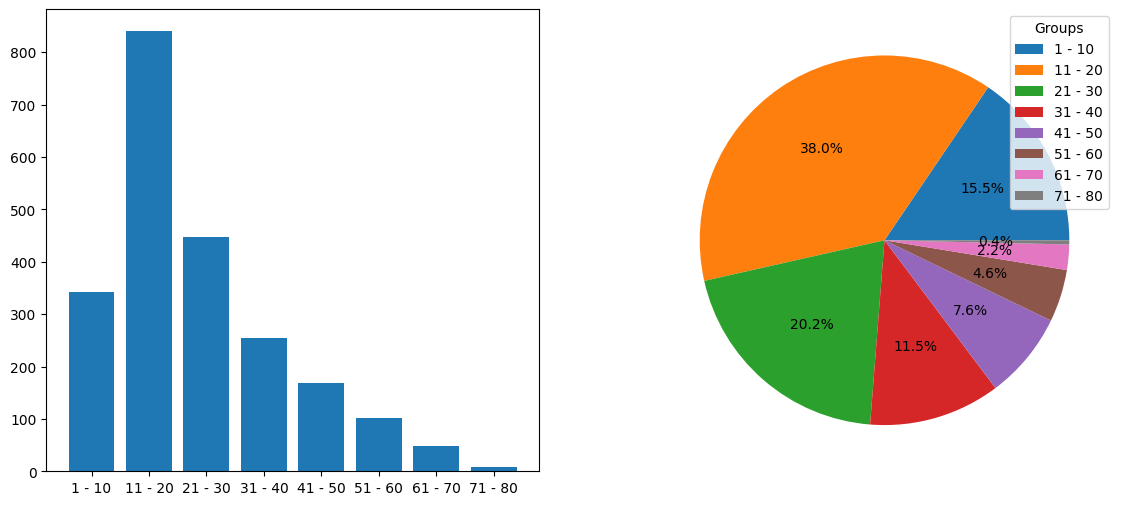

In [38]:
groups = groups_df.index.values
values = groups_df.values.flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.bar(groups, values)
ax2.pie(values, autopct='%1.1f%%')
ax2.legend(groups, title='Groups')

plt.show()

Так как я не обладаю хорошими вычислительными мощностями, мной было принято решение удалить группы в диапазоне 25-80. Потери составляют чуть больше 27%

In [39]:
data = data[data['CountWords'] <= 24]
data.head()

,Quote,Clear,CountWords,Groups
1,"Ничто так не способствует успокоению ума, как...",ничто так не способствует успокоению ума как у...,9,1 - 10
2,Никогда не тратьте впустую время на что-то важ...,никогда не тратьте впустую время на что-то важ...,18,11 - 20
4,""" Иногда потеря домашнего животного более боле...",иногда потеря домашнего животного более болезн...,22,21 - 30
5,""" То, что лежит позади вас и что лежит перед ...",то что лежит позади вас и что лежит перед вами...,19,11 - 20
8,Прелесть сотрудничества между старшим и младши...,прелесть сотрудничества между старшим и младши...,22,21 - 30


In [40]:
data.describe()

,CountWords
count,1428.000000
mean,13.810924
std,5.289049
min,2.000000
25%,10.000000
50%,13.000000
75%,18.000000
max,24.000000


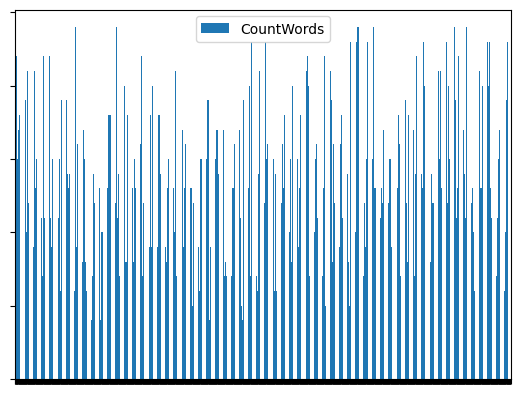

In [41]:
# Проанализируем распределение
ax = data.plot.bar(x=None, y='CountWords')

ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()

Выводы по анализу количества слов: Удалось снизить среднее значение количества слов, без значительных потерь. 75% Данных лежат в диапазоне до 18 слов. При этом std и график распределения говорят о разнообразности набора.  

In [42]:
data[['Quote', 'Clear']].to_csv(f'data/clear_data_up_to_24.csv', index=False)

### Анализ самих слов в цитатах 

In [4]:
data = pd.read_csv('data/clear_data_up_to_24.csv')
data.head()

,Quote,Clear
0,"Ничто так не способствует успокоению ума, как...",ничто так не способствует успокоению ума как у...
1,Никогда не тратьте впустую время на что-то важ...,никогда не тратьте впустую время на что-то важ...
2,""" Иногда потеря домашнего животного более боле...",иногда потеря домашнего животного более болезн...
3,""" То, что лежит позади вас и что лежит перед ...",то что лежит позади вас и что лежит перед вами...
4,Прелесть сотрудничества между старшим и младши...,прелесть сотрудничества между старшим и младши...


In [5]:
word_counts = pd.Series(' '.join(data['Clear']).split()).value_counts()
word_counts_df = word_counts.reset_index().rename(columns={'index': 'Word'})
display(word_counts.shape[0])
word_counts_df.head(10)

6316

,Word,count
0,и,502
1,не,493
2,в,441
3,что,405
4,это,397
5,я,351
6,на,179
7,как,175
8,ты,169
9,вы,162


In [6]:
word_counts_df['LenWord'] = word_counts_df['Word'].str.len()
word_counts_df.sort_values(['LenWord'])

,Word,count,LenWord
0,и,502,1
4093,н,1,1
2773,л,1,1
1092,1,2,1
1107,-,2,1
...,...,...,...
5727,антиинтеллектуализм,1,19
5263,конкурентоспособность,1,21
4274,причинно-следственной,1,21
3531,институционализированное,1,24


Проанализируем странные слова длиной 1

In [7]:
word_counts_df[word_counts_df['LenWord'] == 1]

,Word,count,LenWord
0,и,502,1
2,в,441,1
5,я,351,1
10,с,143,1
19,у,92,1
21,а,88,1
22,к,87,1
30,о,71,1
738,ж,3,1
1092,1,2,1


In [8]:
str_words = word_counts_df[(word_counts_df['LenWord'] == 1) & (word_counts_df['count'] < 10)]['Word'].values
str_words

array(['ж', '1', '-', '5', '6', 'б', 'л', 'г', 'н'], dtype=object)

In [9]:
def find_word(word):
    return data[data['Clear'].str.contains(word)]['Clear']

for word in str_words:
    display(f' {word} ')
    print(find_word(f' {word} ').values)

' ж '

['что ж я безусловно усвоил урок и надеюсь двигаться дальше и безусловно два года тюрьмы были ужасным наказанием'
 'что ж я просто надеюсь что у нас может быть мир и я надеюсь что это принесет какую-то пользу'
 'ну что ж я просто подумал что если бы ты умер я бы пригласил тебя разделить со мной туалет']


' 1 '

['о научи меня как я должен забыть думать 1 1 224']


' - '

[]


' 5 '

['избитые женщины 5 избитые женщины более хрустящие'
 'что я надеваю в постель почему шанель 5 конечно']


' 6 '

['есть 6 причин по которым человек делает что-либо любовь вера жадность скука страх месть']


' б '

['нет причин иметь план б потому что это отвлекает от плана а']


' л '

['кира ты знаешь что такое яблоки боги смертельной любви л черт бы тебя побрал кира']


' г '

[]


' н '

[]


Странно, что некоторых вхождений нет... А так все нормально

Выводы: удалось сократить максимальную длину предложения до 24 слов. Уникальных слов 6316, можно попробовать использовать токенизацию по словам или embedding

## Подготовка данных под обучение (токенизация и векторизация)

In [145]:
data = pd.read_csv('data/clear_data_up_to_24.csv')
data.head()

,Quote,Clear
0,"Ничто так не способствует успокоению ума, как...",ничто так не способствует успокоению ума как у...
1,Никогда не тратьте впустую время на что-то важ...,никогда не тратьте впустую время на что-то важ...
2,""" Иногда потеря домашнего животного более боле...",иногда потеря домашнего животного более болезн...
3,""" То, что лежит позади вас и что лежит перед ...",то что лежит позади вас и что лежит перед вами...
4,Прелесть сотрудничества между старшим и младши...,прелесть сотрудничества между старшим и младши...


In [146]:
corpus = pd.DataFrame(data['Clear'])
corpus.head()

,Clear
0,ничто так не способствует успокоению ума как у...
1,никогда не тратьте впустую время на что-то важ...
2,иногда потеря домашнего животного более болезн...
3,то что лежит позади вас и что лежит перед вами...
4,прелесть сотрудничества между старшим и младши...


In [ ]:
vocab = Vocab(corpus)
print(vocab.idx_to_token)

In [148]:
corpus['Clear'] = corpus['Clear'].apply(lambda x: '<BOS> ' + x +' <EOS>')
corpus

,Clear
0,<BOS> ничто так не способствует успокоению ума...
1,<BOS> никогда не тратьте впустую время на что-...
2,<BOS> иногда потеря домашнего животного более ...
3,<BOS> то что лежит позади вас и что лежит пере...
4,<BOS> прелесть сотрудничества между старшим и ...
...,...
1423,<BOS> многие шаги предпринятые с сомнением быс...
1424,<BOS> дружба не нужна как философия как искусс...
1425,<BOS> искусство никогда не следует рассматрива...
1426,<BOS> милая принесите копию моего завещания и ...


In [149]:
train = corpus.iloc[:int(0.8*len(corpus))]
test = corpus.iloc[int(0.8*len(corpus)):] 

In [150]:
train.to_csv(f'data/train.csv', index=False)
test.to_csv(f'data/test.csv', index=False)

Обучение моделей будет производиться в colab, поэтому сами модели и подготовка данных для них будут в других ноутбуках 